In [2]:
from math import pi, sqrt, floor, ceil

from PIL import Image
from PIL.ImageFile import ImageFile
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
import ipywidgets

In [17]:
def load_bitmap(filename: str) -> ImageFile:
    image = Image.open("./obrazy/" + filename)
    return image


def calculateEmittersDetectorsPositions(
    image_start,
    radius,
    scans_count,
    detectors_count,
    alfa_step,
    detectors_angular_aperture,
):
    # All emitters and detectors positions set to (radius, radius)
    emitter_positions = np.full(
        (scans_count, detectors_count, 2), radius, dtype=np.float64
    )
    detector_positions = np.full(
        (scans_count, detectors_count, 2), radius, dtype=np.float64
    )

    # All emitters angles set to 0 rad
    emitter_angles = np.zeros((scans_count, detectors_count), dtype=np.float64)

    # All detectors angles set to pi rad
    detector_angles = np.full((scans_count, detectors_count), pi, dtype=np.float64)

    # Angle differences between scans
    scan_start_angles = np.arange(
        0, scans_count * alfa_step, alfa_step, dtype=np.float64
    )

    # Update emitters and detectors angles to include difference in angle between scans
    emitter_angles += scan_start_angles[:, np.newaxis]
    detector_angles += scan_start_angles[:, np.newaxis]

    # Angle differences between detectors/emitters
    detector_angle_differences = np.linspace(
        -detectors_angular_aperture / 2,
        detectors_angular_aperture / 2,
        detectors_count,
        dtype=np.float64,
    )
    
    # Update emitters and detectors angles to include difference in angle between detectors/emitters
    emitter_angles -= detector_angle_differences
    detector_angles += detector_angle_differences

    # Calculate coordinates of emitters
    emitter_positions_x = np.cos(emitter_angles, dtype=np.float64)
    emitter_positions_y = np.sin(emitter_angles, dtype=np.float64)
    emitter_positions_xy = np.stack(
        (emitter_positions_x, emitter_positions_y), axis=-1, dtype=np.float64
    )
    emitter_positions *= emitter_positions_xy

    # Calculate coordinates of detectors
    detector_positions_x = np.cos(detector_angles, dtype=np.float64)
    detector_positions_y = np.sin(detector_angles, dtype=np.float64)
    detector_positions_xy = np.stack(
        (detector_positions_x, detector_positions_y), axis=-1, dtype=np.float64
    )
    detector_positions *= detector_positions_xy

    # Shift coordinates to match with image
    emitter_positions -= image_start[np.newaxis, np.newaxis, :]
    detector_positions -= image_start[np.newaxis, np.newaxis, :]

    return emitter_positions, detector_positions


def calcualateIntesections(
    image_width, image_height, emitter_positions, detector_positions
):
    # Calculate last indexes of image
    max_x = image_width - 1
    max_y = image_height - 1

    # Calculate standard forms of linear equation for all rays between detectors and emitters ( Ax + By = C )
    A_values = detector_positions[:, :, 1] - emitter_positions[:, :, 1]
    B_values = emitter_positions[:, :, 0] - detector_positions[:, :, 0]
    C_values = (
        A_values * emitter_positions[:, :, 0] + B_values * emitter_positions[:, :, 1]
    )

    # Calculate intersections of rays and image boundaries or -1 if lines are parallel
    # Round is for treating very small float numbers as 0 (1e-10 -> 0)
    # for x = 0 (left side of image)
    y1 = np.divide(
        C_values, B_values, out=np.full_like(C_values, -1), where=B_values != 0
    ).round(9)
    # for x = max_x (right side of image)
    y2 = np.divide(
        C_values - (A_values * max_x),
        B_values,
        out=np.full_like(C_values, -1),
        where=B_values != 0,
    ).round(9)
    # for y = 0 (top side of image)
    x1 = np.divide(
        C_values, A_values, out=np.full_like(C_values, -1), where=A_values != 0
    ).round(9)
    # remove points that are repeated
    x1[(x1 == 0) & (y1 == 0)] = -1
    x1[(x1 == max_x) & (y2 == 0)] = -1
    # for y = max_y (bottom side of image)
    x2 = np.divide(
        C_values - (B_values * max_y),
        A_values,
        out=np.full_like(C_values, -1),
        where=A_values != 0,
    ).round(9)
    # remove points that are repeated
    x2[(x2 == 0) & (y1 == max_y)] = -1
    x2[(x2 == max_x) & (y2 == max_y)] = -1

    # Get full coordinates of intersection points
    # for x = 0 (left side of image)
    intersections_1 = np.stack([np.zeros_like(y1), y1], axis=-1)
    # for x = max_x (right side of image)
    intersections_2 = np.stack([np.full_like(y2, max_x), y2], axis=-1)
    # for y = 0 (top side of image)
    intersections_3 = np.stack([x1, np.zeros_like(x1)], axis=-1)
    # for y = max_y (bottom side of image)
    intersections_4 = np.stack([x2, np.full_like(x2, max_y)], axis=-1)

    # Merge all intersections
    intersections = np.stack(
        [intersections_1, intersections_2, intersections_3, intersections_4], axis=-2
    )

    # Check if intersection points are inside image
    # for x = 0 (left side of image)
    is_inside_image_1 = (0 <= intersections_1[:, :, 1]) & (
        intersections_1[:, :, 1] <= max_y
    )
    # for x = max_x (right side of image)
    is_inside_image_2 = (0 <= intersections_2[:, :, 1]) & (
        intersections_2[:, :, 1] <= max_y
    )
    # for y = 0 (top side of image)
    is_inside_image_3 = (0 <= intersections_3[:, :, 0]) & (
        intersections_3[:, :, 0] <= max_x
    )
    # for y = max_y (bottom side of image)
    is_inside_image_4 = (0 <= intersections_4[:, :, 0]) & (
        intersections_4[:, :, 0] <= max_x
    )

    # Merge all checks
    is_inside_image = np.stack(
        [is_inside_image_1, is_inside_image_2, is_inside_image_3, is_inside_image_4],
        axis=-1,
    )

    return intersections, is_inside_image


def getLinePixels(start, end):
    d0 = end[0] - start[0]
    d1 = end[1] - start[1]
    if np.abs(d0) > np.abs(d1):
        x = np.arange(start[0], end[0] + np.sign(d0), np.sign(d0), dtype=np.int32)
        n = len(x)
        y = np.linspace(start[1], end[1], n, endpoint=True, dtype=np.int32)
        return (y, x)
    else:
        y = np.arange(start[1], end[1] + np.sign(d1), np.sign(d1), dtype=np.int32)
        n = len(y)
        x = np.linspace(start[0], end[0], n, endpoint=True, dtype=np.int32)
        return (y, x)


def calculateRayPixels(current_intersections, current_is_inside_image):
    # Find which intersections are correct
    end_points = current_intersections[current_is_inside_image]

    if end_points.shape[0] == 0:
        # If no intersections are correct then ray is entirely outside image
        return tuple(([], []))

    if end_points.shape[0] == 1:
        # If only one intersection is correct then ray pass only through 1 pixel
        x, y = end_points[0]
        return tuple(([int(x)], [int(y)]))

    # Calculate pixels of image that are passed through between given end_points
    return getLinePixels(end_points[0], end_points[1])


def displayState(image_info, rays_info, sinogram, image_data, scan_number, hasToBeTruncated = False, hasToBeFiltered = False):
    image_filename, image_width, image_height, image_start_x, image_start_y, radius = (
        image_info
    )
    emitter_positions, detector_positions, all_scans_rays = rays_info
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].axis("equal")
    axes[0].set_xlim(
        (-floor(radius * 1.1) - image_start_x, ceil(radius * 1.1) - image_start_x)
    )
    axes[0].set_ylim(
        (ceil(radius * 1.1) - image_start_y, -floor(radius * 1.1) - image_start_x)
    )
    x, y = zip(*(emitter_positions))
    axes[0].plot(x, y, "ro", markersize=2)
    x, y = zip(*(detector_positions))
    axes[0].plot(x, y, "go", markersize=2)
    all_ray_pixels_x = []
    all_ray_pixels_y = []
    for ray in all_scans_rays:
        y, x = ray
        all_ray_pixels_x.extend(np.array(x))
        all_ray_pixels_y.extend(np.array(y))
    x, y = all_ray_pixels_x, all_ray_pixels_y
    axes[0].plot(x, y, "bo", markersize=1, alpha=0.1)
    axes[0].imshow(
        plt.imread(f"obrazy/{image_filename}"),
        extent=(
            0,
            image_width,
            image_height,
            0,
        ),
    )
    axes[0].set_title(f"Rays during scan nr. {scan_number+1}")

    axes[1].imshow(sinogram, cmap="gray")
    axes[1].set_title(f"Sinogram after scan nr. {scan_number+1}")

    scaled_image_data = image_data.copy()
    if hasToBeFiltered:
        from scipy.ndimage import convolve
        kernel_filter_size = 5
        main = 1/25
        temp = 1/25
        kernel_filter = np.full((kernel_filter_size,kernel_filter_size), temp)
        kernel_filter[kernel_filter_size//2,kernel_filter_size//2] = main
        scaled_image_data = convolve(scaled_image_data, kernel_filter, mode = "nearest")
    if hasToBeTruncated:
        n_th_percentile = np.percentile(scaled_image_data, 99)
        n_th_percentile2 = np.percentile(scaled_image_data, 1)
        # scaled_image_data[scaled_image_data<0] = 0
        scaled_image_data[scaled_image_data>n_th_percentile] = n_th_percentile
        scaled_image_data[scaled_image_data<n_th_percentile2] = n_th_percentile2
    axes[2].imshow(scaled_image_data, cmap="gray")
    axes[2].set_title(f"Image after scan nr. {scan_number+1}")

    clear_output(wait=True)
    plt.show()


def simulateComputedTomographyScan(
    image_filename: str,
    scans_count: int,
    alfa_step: float,
    detectors_count: int,
    detectors_angular_aperture: float,
    has_to_use_sinogram_filter: bool = True,
    has_to_save_intermediate_steps: bool = False,
    has_to_show_intermediate_steps: bool = False,
):
    # Load input image
    image = load_bitmap(image_filename)
    image.load()
    image_size = image.size
    image_width, image_height = image_size
    image_pixels = np.asarray(image, dtype=np.float64)
    image_pixels = image_pixels.mean(axis=-1)
    image.close()

    # Inscribe image in circle ( center of circle is center of image )
    # Circle pass through centers of 4 corner pixels of image
    # So its radius is equal to half of diagonal of image reduced by 1 pixel in width and height
    diagonal_length = sqrt(pow(image_width-1, 2) + pow(image_height-1, 2))
    radius = diagonal_length / 2

    # Calculate position of center of pixel (0,0) of image in a emitters and detectors coordinate system
    image_start_x = -image_width // 2 + 0.5
    image_start_y = -image_height // 2 + 0.5
    image_start = np.array([image_start_x, image_start_y])

    image_info = (
        image_filename,
        image_width,
        image_height,
        image_start_x,
        image_start_y,
        radius,
    )

    # Calculate positions of detectors and emitters on circle
    emitter_positions, detector_positions = calculateEmittersDetectorsPositions(
        image_start,
        radius,
        scans_count,
        detectors_count,
        alfa_step,
        detectors_angular_aperture,
    )

    # Calculate intersections and checks which intersections are inside image
    intersections, is_inside_image = calcualateIntesections(
        image_width, image_height, emitter_positions, detector_positions
    )

    # Create matrix of ray pixels
    all_scans_rays = np.empty((scans_count, detectors_count), dtype=np.object_)

    # Create matrix for sinogram data
    sinogram = np.zeros((scans_count, detectors_count), dtype=np.float64)

    # Create kernel used for filtering if needed
    if has_to_use_sinogram_filter:
        # kernel_size = 161
        kernel_size = 21
        while detectors_count < kernel_size:
            kernel_size = ((kernel_size - 1)//2)+1
        kernel_mid_point_index = (kernel_size-1)//2
        kernel = np.zeros(kernel_size)
        kernel[kernel_mid_point_index] = 1
        numerator = -4 / (pi**2)
        for k in range(1, (kernel_mid_point_index)+1, 2):
            kernel_value = (numerator) / (k**2)
            kernel[k + kernel_mid_point_index] = kernel_value
            kernel[-k + kernel_mid_point_index] = kernel_value

    # Create matrix for image data
    image_data = np.zeros((image_height, image_width))
    # image_data_counts = np.zeros((image_height, image_width))

    # Create array of created images
    if has_to_save_intermediate_steps:
        images = np.empty((scans_count, image_height, image_width))

    for scan_number in range(scans_count):
        for detector_number in range(detectors_count):
            # Calculate pixels of image that are passed through between given end_points
            pixels_coords = calculateRayPixels(
                intersections[scan_number, detector_number],
                is_inside_image[scan_number, detector_number],
            )

            all_scans_rays[scan_number, detector_number] = pixels_coords

            current_scan_ray = all_scans_rays[scan_number, detector_number]
            # Check if ray passed through any image pixels
            if len(current_scan_ray[0]) == 0:
                sinogram[scan_number, detector_number] = 0
                continue

            # Calculate average of pixels passed by ray
            sinogram[scan_number, detector_number] = np.mean(
                image_pixels[current_scan_ray]
            )

        # Calculate convolution of sinogram and kernel if needed
        if has_to_use_sinogram_filter:
            sinogram[scan_number] = np.convolve(
                sinogram[scan_number], kernel, mode="same"
            )

        for detector_number in range(detectors_count):
            current_scan_ray = all_scans_rays[scan_number, detector_number]
            # Check if ray passed through any image pixels
            if len(current_scan_ray[0]) == 0:
                continue

            # Add value from sinogram to all pixels passed by ray
            image_data[current_scan_ray] += sinogram[scan_number, detector_number]
            # image_data_counts[current_scan_ray] += 1

        # Save image data
        if has_to_save_intermediate_steps:
            images[scan_number] = image_data.copy()

        # Display optional intermediate stages
        if has_to_show_intermediate_steps:
            rays_info = (
                emitter_positions[scan_number],
                detector_positions[scan_number],
                all_scans_rays[scan_number],
            )
            displayState(image_info, rays_info, sinogram, image_data, scan_number)

    rays_info = (
        emitter_positions[scan_number],
        detector_positions[scan_number],
        all_scans_rays[scan_number],
    )
    # image_data_counts[image_data_counts==0] = 1
    # new_image_data =  np.true_divide(image_data,image_data_counts)
    # new_image_data seems to be worse or at best same as image_data
    displayState(image_info, rays_info, sinogram, image_data, scan_number, True, True)

    if has_to_save_intermediate_steps:
        rays_info = (
            emitter_positions,
            detector_positions,
            all_scans_rays,
        )
        return (image_info, rays_info, sinogram, images)


def showStateAfterScan(states, scan):
    image_info, rays_info, sinogram, images = states
    image_filename, image_width, image_height, image_start_x, image_start_y, radius = (
        image_info
    )
    emitter_positions, detector_positions, all_scans_rays = rays_info

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].axis("equal")
    axes[0].set_xlim(
        (-floor(radius * 1.1) - image_start_x, ceil(radius * 1.1) - image_start_x)
    )
    axes[0].set_ylim(
        (ceil(radius * 1.1) - image_start_y, -floor(radius * 1.1) - image_start_x)
    )
    x, y = zip(*(emitter_positions[scan - 1]))
    axes[0].plot(x, y, "ro", markersize=2)
    x, y = zip(*(detector_positions[scan - 1]))
    axes[0].plot(x, y, "go", markersize=2)
    all_ray_pixels_x = []
    all_ray_pixels_y = []
    for ray in all_scans_rays[scan - 1]:
        y, x = ray
        all_ray_pixels_x.extend(np.array(x))
        all_ray_pixels_y.extend(np.array(y))
    x, y = all_ray_pixels_x, all_ray_pixels_y
    axes[0].plot(x, y, "bo", markersize=1, alpha=0.1)
    axes[0].imshow(
        plt.imread(f"obrazy/{image_filename}"),
        extent=(
            0,
            image_width,
            image_height,
            0,
        ),
    )
    axes[0].set_title(f"Rays during scan nr. {scan}")

    sinogram_after_n_scan = np.zeros_like(sinogram)
    sinogram_after_n_scan[:scan] = sinogram[:scan]
    axes[1].imshow(sinogram_after_n_scan, cmap="gray")
    axes[1].set_title(f"Sinogram after scan nr. {scan}")

    axes[2].imshow(images[scan - 1], cmap="gray")
    axes[2].set_title(f"Image after scan nr. {scan}")

    clear_output(wait=True)
    plt.show()


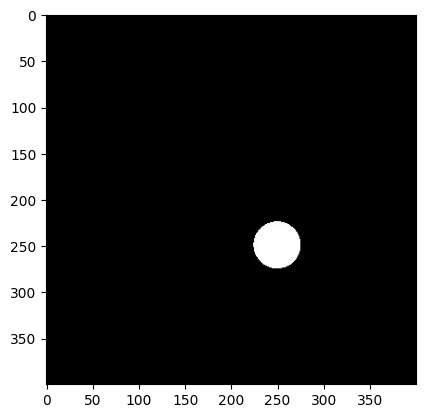

In [4]:
filename = "Kropka.jpg"
# filename = "Shepp_logan.jpg"
# filename = "SADDLE_PE-large.JPG"

scans_count = 180

alfa_step = pi / scans_count

detectors_count = 180

detectors_angular_aperture =  1 * pi

has_to_use_sinogram_filter = True
has_to_save_intermediate_steps = False
has_to_show_intermediate_steps = False

image = load_bitmap(filename)
plt.imshow(image)
image.close()

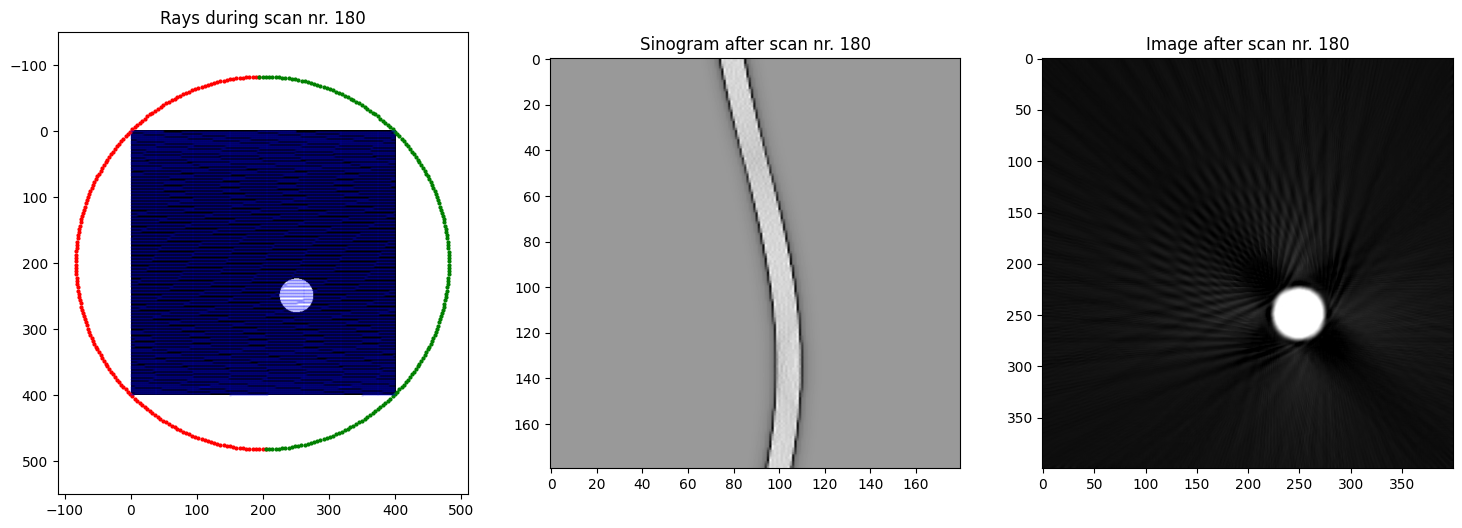

In [19]:
states = simulateComputedTomographyScan(
    filename,
    scans_count,
    alfa_step,
    detectors_count,
    detectors_angular_aperture,
    has_to_use_sinogram_filter,
    has_to_save_intermediate_steps,
    has_to_show_intermediate_steps,
)
# Best if truncated from below (0 or 1-percentile?) and added small low pass filter (blurred 5x5 1/25) and maybe with truncating from above (99-percentile)
# Kernel_size 161

In [6]:
ipywidgets.interact(
    showStateAfterScan,
    states=ipywidgets.fixed(states),
    scan=ipywidgets.IntSlider(min=1, max=scans_count),
)

interactive(children=(IntSlider(value=1, description='scan', max=360, min=1), Output()), _dom_classes=('widget…

<function __main__.showStateAfterScan(states, scan)>

TODO

https://docs.google.com/presentation/d/1SeYwXUH1SB114OJO8NVovHBeupTIpM4muwNpd7r4pO0/edit#slide=id.gc39bab9b14_1_224

1.
Aplikacja powinna pozwalać na odczyt i zapis uzyskanego obrazu w standardzie DICOM wraz z uwzględnieniem (możliwość wprowadzenia z interfejsu):
podstawowych informacji o pacjencie
daty badania
komentarzy
Poprawność zapisanego pliku należy zweryfikować w dowolnej (darmowej) przeglądarce plików DICOM, np. 
https://www.imaios.com/en/Imaios-Dicom-Viewer,
https://www.fviewer.com/pl/view-dicom. 
Uwaga: Należy wykorzystać bibliotekę do obsługi plików DICOM (np. pydicom), nie należy implementować obsługi plików DICOM samodzielnie!

2.
Należy dokonać prostej analizy statystycznej w oparciu o jedną zdefiniowaną miarę jakości. Np. mając obraz wejściowy i wyjściowy można policzyć błąd średniokwadratowy (po wszystkich pikselach różnicy obrazu wejściowego i wyjściowego). Taka analiza powinna uwzględnić następujące elementy:
zmianę błędu średniokwadratowego podczas wykonywania kolejnych iteracji odwrotnej transformaty Radona dla wybranego obrazu,
zmianę błędu średniokwadratowego przy zwiększaniu dokładności próbkowania (trzy uprzednio wymienione parametry modelu emiter/detektor), 
zmianę błędu średniokwadratowy po włączeniu filtrowania. 

3.
Raport
https://docs.google.com/document/d/15zb5myHaLJqZUuv3Wv-gWXCP6wZn44s8QhGeW3izCGg/edit?tab=t.0
